# EC771 - Empirical Assignment: Regression Discontinuity
## Michaela Philip

### Assignment by Professor Ian McCarthy

### All data from Keith M. Marzilli Ericson (2014)

In [7]:
import numpy as np 
import pandas as pd 
from tabulate import tabulate 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

##### 1. Recreate the table of descriptive statistics (Table 1) from Ericson (2014).

In [13]:
from data_code.load_clean_data import main as main
from helpers.descriptive_statistics import get_stats
from helpers.tables import create_table

descriptive_stats = get_stats(main)

table_1 = descriptive_stats.T

index = ['Mean monthly premium', '  ', 'Mean deductible', '  ', 'Fraction enhanced benefit', 'Fraction of US firms', 'Fraction of state firms', 'Number of unique firms', 'Number of plans']
table_1.index = index
table_1

,2006,2007,2008,2009,2010
Mean monthly premium,$37,$40,$36,$30,$33
,(13),(17),(20),(5),(9)
Mean deductible,$92,$114,$146,$253,$118
,(116),(128),(125),(102),(139)
Fraction enhanced benefit,0.43,0.43,0.58,0.03,0.69
Fraction of US firms,0.0,0.76,0.98,1.0,0.97
Fraction of state firms,0.0,0.53,0.91,0.68,0.86
Number of unique firms,51,38,16,5,6
Number of plans,"1,429",658,202,68,107


##### 2. Recreate Figure 3 from Ericson (2014).

In [11]:
from data_code.load_clean_data import full_data as full_data
from helpers.bins import get_bins

full_data = get_bins(full_data, 2006, 20, 10)
results = pd.DataFrame()

#local averages with bin size $0.50, bandwidth of $10, year 2006, no enhanced benefits
condition1 = ((full_data['rd_window_1'] == 1) & (full_data['year'] == 2006) & (full_data['e_ben']==0))
scatter_data = full_data[condition1]
bin_scatter = smf.ols(formula = 'ln_share ~ C(bin)', data = scatter_data).fit()
scatter_data['bin_scatter'] = bin_scatter.predict(scatter_data)

#local linear predition with bandwidth of $4, year 2006, no enhanced benefits
condition2 = ((full_data['rd_window_2'] == 1) & (full_data['year'] == 2006) & (full_data['e_ben']==0))
lin_data = full_data[condition2]
local_lin = smf.ols(formula = 'ln_share ~ below_bench_1 + lis_prem_pos + lis_prem_neg', data = lin_data).fit(cov_type='cluster', cov_kwds={'groups': lin_data['uniqueID']})
lin_data['local_lin'] = local_lin.predict(lin_data)
lin_data_sort = lin_data.sort_values(by='lis_premium')

#quartic polynomial prediction with bandwith of $10, year 2006, no enhanced benefits
condition3 = ((full_data['rd_window_1'] == 1) & (full_data['year'] == 2006) & (full_data['e_ben']==0))
poly_data = full_data[condition3]
quart_poly = smf.ols(formula = 'ln_share ~ below_bench_1 + lis_prem_pos + lis_prem_neg + lis_prem_pos_sq + lis_prem_neg_sq + lis_prem_pos_cu + lis_prem_neg_cu + lis_prem_pos_qu + lis_prem_neg_qu', data = poly_data).fit(cov_type='cluster', cov_kwds={'groups': poly_data['uniqueID']})
poly_data['quart_poly'] = quart_poly.predict(poly_data)
poly_data_sort = poly_data.sort_values(by='lis_premium')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


C:\Users\micha\AppData\Local\Temp\ipykernel_30464\3989478394.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scatter_data['bin_scatter'] = bin_scatter.predict(scatter_data)
C:\Users\micha\AppData\Local\Temp\ipykernel_30464\3989478394.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lin_data['local_lin'] = local_lin.predict(lin_data)
C:\Users\micha\AppData\Local\Temp\ipykernel_30464\3989478394.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

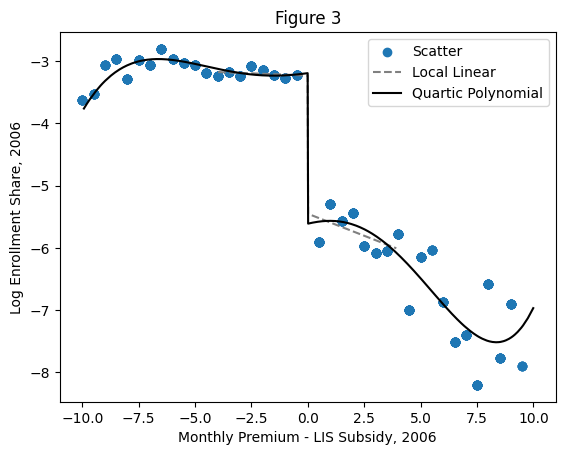

In [12]:
#creating the graph 
ytitle = "Log Enrollment Share, 2006"
plt.scatter(scatter_data['bin'], scatter_data['bin_scatter'], label='Scatter')
plt.plot(lin_data_sort['lis_premium'], lin_data_sort['local_lin'], linestyle='dashed', color='gray', label='Local Linear')
plt.plot(poly_data_sort['lis_premium'], poly_data_sort['quart_poly'], linestyle='solid', color='black', label='Quartic Polynomial')
plt.xlabel("Monthly Premium - LIS Subsidy, 2006")
plt.ylabel(ytitle)
plt.title("Figure 3")
plt.legend()
plt.show()

##### 3. Calonico, Cattaneo, and Titiunik (2015) discuss the appropriate partition size for binned scatterplots such as that in Figure 3 of Ericson (2014). More formally, denote by $\mathbb{P}_{-,n} = \{P_{-,j} : j = 1, 2, ...J_{-,n}\}$ and $\mathbb{P_{+,n}} = \{P_{+,j} : j = 1, 2, ...J_{+,n}\}$ the partitions of the support of the running variable $x_i$ on the left and right (respectively) of the cutoff, $\bar{x}$. $P_{-,j}$ and $P_{+,n}$ denote the actual supports for each $j$ partition of size $J_{-,n}$ and $J_{+,n}$ such that $[x_l, \bar{x}) = \cup_{j=1}^{J_{-.n}} P_{-,j}$ and $(\bar{x}, x_u] = \cup_{j=1}^{J_{+,n}} P_{+,j}$. Individual bins are denoted by $p_{-,j}$ and $p_{+,j}$. With this notation in hand, we can write the partitions $J_{-,n}$ and $J_{+,n}$ with equally-spaced bins as $$ p_{-,j} = x_l + j \times \frac{\bar{x}-x_l}{J_{-,n}}$$ and $$p_{+,j} = \bar{x} + j \times \frac{x_u - \bar{x}}{J_{+,n}}$$ Recreate Figure 3 from Ericson (2014) using $J_{-,n} = J_{+,n} = 10$ and $J_{-,n} = J_{+,n} = 30$ Discuss your results and compare them to your figure in Part 2. 

##### 4. With the notation above, Calonico, Cattaneo, and Titiunik (2015) derive the optimal number of partitions for an evenly-spaced (ES) RD plot. They show that $$J_{ES, -, n} = [\frac{V_-}{\mathbb{V}_{ES,-}} \frac{n}{\log(n)^2}]$$ and $$J_{ES, +, n} = [\frac{V_+}{\mathbb{V}_{ES,+}} \frac{n}{\log(n)^2}]$$ where $V_-$ and $V_+$ denote the sample variance of the subsamples to the left and right of the cutoff and $\Nu_{ES}$ is an integrated variance term derived in the paper. Use the rdrobust package in R (or Stata or Python) to find the optimal number of bins with an evenly-spaced binning strategy. Report this bin count and recreate your binned scatterplots from parts 2 and 3 based on the optimal bin number.

##### 5. One key underlying assumption for RD design is that agents cannot precisely manipulate the running variable. While “precisely” is not very scientific, we can at least test for whether there appears to be a discrete jump in the running variable around the threshold. Evidence of such a jump may suggest that manipulation is present. Provide the results from the manipulation tests described in Cattaneo, Jansson, and Ma (2018). This test can be implemented with the rddensity package in R, Stata, or Python.

##### 6. Recreate Panels A and B of Table 3 in Ericson (2014) using the same bandwidth of $4.00 but without any covariates.

##### 7. Calonico, Cattaneo, and Farrell (2020) show that pre-existing optimal bandwidth calculations (such as those used in Ericson (2014)) are invalid for appropriate inference. They propose an alternative method to derive minimal coverage error (CE)-optimal bandwidths. Re-estimate your RD results using the CE-optimal bandwidth (rdrobust will do this for you) and compare the bandwidth and RD estimates to that in Table 3 of Ericson (2014).

##### 8. Now let’s extend the analysis in Section V of Ericson (2014) using IV. Use the presence of Part D low-income subsidy as an IV for market share to examine the effect of market share in 2006 on future premium changes.

##### 9. Discuss your findings and compare results from different binwidths and bandwidths. Compare your results in part 8 to the invest-then-harvest estimates from Table 4 in Ericson (2014).

##### 10. Reflect on this assignment. What did you find most challenging? What did you find most surprising?